#  AT82.05 Artificial Intelligence: Natural Language Understanding (NLU)

## A5: Optimization Human Preference

### Name: Arya Shah
### StudentID: st125462

-----------

In this assignment, I will be using Hugging Face models to optimize human preference, specifically leveraging the Direct Preference Optimization (DPO) trainer. Work with preference datasets, train a model, and push it to the Hugging Face model hub

You can find the GitHub Repository for the assignment here:
- https://github.com/aryashah2k/NLP-NLU (Complete Web App)
- https://github.com/aryashah2k/NLP-NLU/tree/main/notebooks (Assignment Notebooks)
- https://github.com/aryashah2k/NLP-NLU/tree/main/reports (Assignment Reports)
- Hugging Face Repository: https://huggingface.co/aryashah00/dpo-TinyLlama-1.1B-Chat-v1.0-20250228-2003

# Task 1. Finding a Suitable Dataset (0.5 point) ✅
1) Select a publicly available dataset for preference optimization tasks, such as human preference
rankings or reinforcement learning from human feedback (RLHF) datasets.✅
2) Ensure that the dataset is properly preprocessed and suitable for training a preference-based model.✅
3) Document the dataset source and preprocessing steps.✅

NOTE: You can use datasets from Hugging Face Datasets Hub

## Dataset Used By Me:

### Anthropic HH-RLHF Dataset

The Anthropic Human Helpfulness and Harmlessness Reinforcement Learning from Human Feedback (HH-RLHF) dataset is a comprehensive collection of human preference data designed specifically for training language models to be both helpful and harmless. Released by Anthropic, this dataset has become a foundational resource for alignment research in large language models.

#### Dataset Overview

The HH-RLHF dataset consists of paired responses to various prompts, where human annotators have indicated their preference between two possible model outputs. Each data point contains:

A prompt or question
A "chosen" response (preferred by human annotators)
A "rejected" response (less preferred by human annotators)
The dataset is organized into two main categories:

1. Helpfulness Data: Focuses on making language models more useful and responsive to human needs. This data is further divided into three tranches:
- Base model responses (from context-distilled 52B language models)
- Rejection-sampled responses (mostly with best-of-16 sampling against an early preference model)
- Online learning responses (collected during iterative training)

2. Harmlessness Data: Designed to reduce harmful, unethical, or dangerous outputs from language models. This data was collected only from base models.

#### Data Collection Methodology

The data was collected through a rigorous process involving human annotators who evaluated pairs of model responses. Annotators were asked to select which response better fulfilled criteria related to helpfulness (providing useful information) or harmlessness (avoiding potentially harmful content).

#### Citation
When using or referencing the Anthropic HH-RLHF dataset, please cite the original paper:

```code
@article{bai2022training,
  title={Training a Helpful and Harmless Assistant with Reinforcement Learning from Human Feedback},
  author={Bai, Yuntao and Jones, Andy and Ndousse, Kamal and Askell, Amanda and Chen, Anna and DasSarma, Nova and Drain, Dawn and Fort, Stanislav and Ganguli, Deep and Henighan, Tom and others},
  journal={arXiv preprint arXiv:2204.05862},
  year={2022}
}
```
#### Dataset Access
The dataset is publicly available through the Hugging Face Datasets library and can be accessed at: https://huggingface.co/datasets/Anthropic/hh-rlhf

The original repository with additional documentation is available at: https://github.com/anthropics/hh-rlhf

# Task 2. Training a Model with DPOTrainer✅
1) Implement the Direct Preference Optimization (DPO) training method with DPOTrainer Function using a pre-trained transformer model (such as GPT, or T5) on the Hugging Face and fine-tune it using the selected dataset. (1 point) ✅
2) Experiment with hyperparameters and report training performance. (1 point) ✅

HINT: Refer to the Hugging Face documentation for DPOTrainer implementation. 

Note: You do not need to train large model sizes like 1B-7B if your GPU is not capable. This assignment focuses on how to use pre-trained models with Hugging Face.

# Task 3. Pushing the Model to Hugging Face Hub (0.5 point)✅
1) Save the trained model. ✅
2) Upload the model to the Hugging Face Model Hub. ✅
3) Provide a link to your uploaded model in your documentation. ✅

NOTE: Make sure your repository is public3 and also the README.md should also contain the link to your publicly available trained model on Hugging Face.✅

Link to HuggingFace Repo: https://huggingface.co/aryashah00/dpo-TinyLlama-1.1B-Chat-v1.0-20250228-2003

In [ ]:
#!/usr/bin/env python
# coding: utf-8

"""
Complete Direct Preference Optimization (DPO) Training Script

This script implements a comprehensive DPO training solution for language models
using the TRL library. It includes dataset preprocessing, model training with QLoRA,
visualization of training metrics, and proper logging.

Author: Arya
Date: February 2025
"""

import os
import logging
import datetime
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple
import getpass

import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainerCallback,
    TrainerState,
    TrainerControl,
    BitsAndBytesConfig,
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from huggingface_hub import login, create_repo, HfApi  # Add create_repo and HfApi

# Import TRL components
from trl import DPOTrainer, DPOConfig

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("dpo_training.log"),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

if torch.cuda.is_available():
    logger.info(f"GPU Name: {torch.cuda.get_device_name(0)}")
    # Get GPU memory in GB
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    logger.info(f"Available GPU memory: {gpu_memory:.2f} GB")


def authenticate_huggingface():
    """
    Authenticate with the Hugging Face Hub.
    
    This function checks for a Hugging Face token in the environment variables.
    If not found, it prompts the user to enter their token.
    
    Returns:
        str: The Hugging Face username for model uploads
    """
    # Get Hugging Face token
    hf_token = os.environ.get("HF_TOKEN")
    if not hf_token:
        logger.info("Hugging Face token not found in environment variables.")
        print("\n" + "="*50)
        print("Please enter your Hugging Face token to authenticate.")
        print("You can find your token at: https://huggingface.co/settings/tokens")
        print("="*50 + "\n")
        
        # Use getpass for secure password input
        hf_token = getpass.getpass("Enter your Hugging Face token: ")
        
        if not hf_token:
            logger.error("No token provided. Cannot authenticate with Hugging Face Hub.")
            raise ValueError("Hugging Face token is required for this script.")
    
    # Set the token for this session
    os.environ["HF_TOKEN"] = hf_token
    
    # Get Hugging Face username
    hf_username = input("Enter your Hugging Face username: ")
    if not hf_username:
        logger.error("No username provided. Cannot push to Hugging Face Hub.")
        raise ValueError("Hugging Face username is required for this script.")
    
    # Login to Hugging Face Hub
    try:
        login(token=hf_token)
        logger.info(f"Successfully authenticated with Hugging Face Hub as {hf_username}")
        return hf_username
    except Exception as e:
        logger.error(f"Error authenticating with Hugging Face Hub: {e}")
        raise RuntimeError(f"Failed to authenticate with Hugging Face Hub: {e}")


class TrainingVisualizer:
    """
    Class for visualizing training metrics during DPO training.
    """
    def __init__(self, output_dir="./visualizations"):
        """
        Initialize the training visualizer.
        
        Args:
            output_dir (str): Directory to save visualization plots
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Initialize metrics storage
        self.train_losses = []
        self.eval_losses = []
        self.reward_accuracies = []
        self.steps = []
        self.timestamps = []
        self.start_time = datetime.datetime.now()
        
        logger.info(f"Training visualizer initialized. Plots will be saved to {output_dir}")
    
    def add_metrics(self, step, train_loss, eval_loss=None, reward_accuracy=None):
        """
        Add metrics at a training step.
        
        Args:
            step (int): Current training step
            train_loss (float): Training loss value
            eval_loss (float, optional): Evaluation loss value
            reward_accuracy (float, optional): Reward accuracy value
        """
        self.steps.append(step)
        self.train_losses.append(train_loss)
        self.timestamps.append((datetime.datetime.now() - self.start_time).total_seconds() / 60)  # minutes
        
        if eval_loss is not None:
            self.eval_losses.append(eval_loss)
        
        if reward_accuracy is not None:
            self.reward_accuracies.append(reward_accuracy)
    
    def plot_losses(self):
        """Plot training and evaluation losses."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.steps, self.train_losses, label='Training Loss')
        
        if self.eval_losses:
            # Ensure eval_losses has the same length as steps by padding with None
            padded_eval_losses = self.eval_losses + [None] * (len(self.steps) - len(self.eval_losses))
            # Filter out None values for plotting
            eval_steps = [self.steps[i] for i in range(len(padded_eval_losses)) if padded_eval_losses[i] is not None]
            eval_losses = [loss for loss in self.eval_losses if loss is not None]
            plt.plot(eval_steps, eval_losses, label='Evaluation Loss')
        
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('DPO Training and Evaluation Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Save the plot
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        plt.savefig(os.path.join(self.output_dir, f"dpo_losses_{timestamp}.png"))
        plt.close()
    
    def plot_reward_accuracy(self):
        """Plot reward accuracy."""
        if not self.reward_accuracies:
            logger.warning("No reward accuracy data to plot")
            return
        
        plt.figure(figsize=(10, 6))
        # Ensure reward_accuracies has the same length as steps by padding with None
        padded_reward_accuracies = self.reward_accuracies + [None] * (len(self.steps) - len(self.reward_accuracies))
        # Filter out None values for plotting
        reward_steps = [self.steps[i] for i in range(len(padded_reward_accuracies)) if padded_reward_accuracies[i] is not None]
        reward_accuracies = [acc for acc in self.reward_accuracies if acc is not None]
        
        plt.plot(reward_steps, reward_accuracies)
        plt.xlabel('Training Steps')
        plt.ylabel('Reward Accuracy')
        plt.title('DPO Reward Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Save the plot
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        plt.savefig(os.path.join(self.output_dir, f"dpo_reward_accuracy_{timestamp}.png"))
        plt.close()
    
    def plot_training_time(self):
        """Plot training time progression."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.steps, self.timestamps)
        plt.xlabel('Training Steps')
        plt.ylabel('Time (minutes)')
        plt.title('DPO Training Time Progression')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Save the plot
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        plt.savefig(os.path.join(self.output_dir, f"dpo_training_time_{timestamp}.png"))
        plt.close()
    
    def save_all_plots(self):
        """Generate and save all plots."""
        self.plot_losses()
        self.plot_reward_accuracy()
        self.plot_training_time()
        logger.info(f"All plots saved to {self.output_dir}")


class MetricsCallback(TrainerCallback):
    """
    Callback to collect metrics during training for visualization.
    """
    def __init__(self, visualizer):
        """
        Initialize the metrics callback.
        
        Args:
            visualizer (TrainingVisualizer): Visualizer instance to record metrics
        """
        self.visualizer = visualizer
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Called when logs are saved.
        
        Args:
            args: Training arguments
            state: Trainer state
            control: Trainer control
            logs: Current logs
        """
        if logs is None:
            return
        
        # Extract metrics from logs
        step = state.global_step
        
        # Extract training loss if available
        train_loss = logs.get("loss")
        
        # Extract evaluation loss and reward accuracy if available
        eval_loss = logs.get("eval_loss")
        reward_accuracy = logs.get("eval_rewards/accuracy")
        
        # Add metrics to visualizer
        if train_loss is not None:
            self.visualizer.add_metrics(step, train_loss, eval_loss, reward_accuracy)
            
            # Generate plots every 100 steps or when specifically requested
            if step % 100 == 0 or state.is_world_process_zero:
                self.visualizer.save_all_plots()


def preprocess_dataset(dataset_train, dataset_eval, num_train_samples=1000, num_eval_samples=100):
    """
    Preprocess the dataset for DPO training.
    
    Args:
        dataset_train: Training dataset
        dataset_eval: Evaluation dataset
        num_train_samples (int): Number of training samples to use
        num_eval_samples (int): Number of evaluation samples to use
        
    Returns:
        Tuple[Dataset, Dataset]: Processed training and evaluation datasets
    """
    # Limit dataset size for faster training/testing
    train_dataset = dataset_train.select(range(min(num_train_samples, len(dataset_train))))
    eval_dataset = dataset_eval.select(range(min(num_eval_samples, len(dataset_eval))))
    
    return train_dataset, eval_dataset


def train_model_with_dpo(train_dataset, eval_dataset, model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0", hf_username=None):
    """
    Train a language model using Direct Preference Optimization.
    
    Args:
        train_dataset: Training dataset with prompts, chosen, and rejected responses
        eval_dataset: Evaluation dataset with prompts, chosen, and rejected responses
        model_name (str): Name of the base model to use
        hf_username (str): Hugging Face username for model uploads
        
    Returns:
        Tuple[PreTrainedModel, PreTrainedTokenizer, str]: Trained model, tokenizer, and model path
    """
    logger.info("Setting up model for DPO training...")
    
    # Model configuration
    logger.info(f"Loading model: {model_name}")
    
    # Configure 4-bit quantization
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    
    # Load model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        quantization_config=quantization_config,
    )
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"  # Set padding side
    
    logger.info("Model loaded successfully")
    
    # Prepare model for training with LoRA
    model = prepare_model_for_kbit_training(model)
    
    # LoRA configuration
    peft_config = LoraConfig(
        r=16,  # Rank of the update matrices
        lora_alpha=32,  # Alpha parameter for LoRA scaling
        lora_dropout=0.05,  # Dropout probability for LoRA layers
        bias="none",  # Bias type
        task_type="CAUSAL_LM",  # Task type
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    )
    
    # Apply LoRA config to the model
    model = get_peft_model(model, peft_config)
    logger.info("LoRA configuration applied to model")
    
    # Print trainable parameters
    model.print_trainable_parameters()
    
    # Initialize training visualizer
    visualizer = TrainingVisualizer()
    
    # Set up DPO configuration
    dpo_config = DPOConfig(
        output_dir="./dpo_results",
        num_train_epochs=5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,
        learning_rate=5e-5,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        logging_steps=10,
        eval_strategy="steps",  # Use this instead of evaluation_strategy
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        fp16=True,
        gradient_checkpointing=True,
        remove_unused_columns=False,
        report_to="none",  # Disable default logging to use our custom visualizer
        push_to_hub=False,  # Disable pushing to Hugging Face Hub during training
        beta=0.1,
    )
    
    logger.info("Setting up DPO Trainer...")
    
    # Initialize DPO trainer
    dpo_trainer = DPOTrainer(
        model=model,
        ref_model=None,  # Set to None when using PEFT
        args=dpo_config,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=AutoTokenizer.from_pretrained(model_name),
        peft_config=peft_config,
        callbacks=[MetricsCallback(visualizer)]
    )
    
    # Train the model
    logger.info("Starting DPO training...")
    try:
        dpo_trainer.train()
        logger.info("DPO training completed successfully")
    except Exception as e:
        logger.error(f"Error during DPO training: {e}")
        raise
    
    # Save the final model
    output_dir = "./dpo_final_model"
    dpo_trainer.save_model(output_dir)
    logger.info(f"Model saved to {output_dir}")
    
    # Generate and save final plots
    visualizer.save_all_plots()
    
    # Push to Hugging Face Hub (required)
    logger.info("Preparing to push model to Hugging Face Hub...")
    
    # Generate a unique model ID with username
    if hf_username:
        hub_model_id = f"{hf_username}/dpo-{model_name.split('/')[-1]}-{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
    else:
        hub_model_id = f"dpo-{model_name.split('/')[-1]}-{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
        logger.warning("No username provided, using generic model ID")
    
    try:
        # Push the model to the Hub
        logger.info(f"Pushing model to Hugging Face Hub as {hub_model_id}")
        
        # First, save the model to a temporary directory with the correct repo name
        temp_output_dir = f"./temp_{hub_model_id.replace('/', '_')}"
        dpo_trainer.save_model(temp_output_dir)
        logger.info(f"Model saved to temporary directory: {temp_output_dir}")
        
        # Create a new repository on the Hub and push the model
        from huggingface_hub import create_repo, HfApi
        
        # Create the repository if it doesn't exist
        try:
            create_repo(hub_model_id, token=os.environ["HF_TOKEN"], exist_ok=False)
            logger.info(f"Created new repository: {hub_model_id}")
        except Exception as repo_error:
            logger.warning(f"Repository creation error (may already exist): {repo_error}")
        
        # Use HfApi to push the model files
        api = HfApi()
        api.upload_folder(
            folder_path=temp_output_dir,
            repo_id=hub_model_id,
            token=os.environ["HF_TOKEN"],
        )
        
        # Clean up the temporary directory
        import shutil
        try:
            shutil.rmtree(temp_output_dir)
            logger.info(f"Temporary directory cleaned up: {temp_output_dir}")
        except Exception as cleanup_error:
            logger.warning(f"Failed to clean up temporary directory: {cleanup_error}")
        
        logger.info(f"Model successfully pushed to Hugging Face Hub: {hub_model_id}")
        print(f"\nModel successfully pushed to Hugging Face Hub: {hub_model_id}")
    except Exception as e:
        logger.error(f"Error pushing model to Hugging Face Hub: {e}")
        raise RuntimeError(f"Failed to push model to Hugging Face Hub: {e}")
    
    return model, tokenizer, output_dir


def run_dpo_training(model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0", hf_username=None):
    """
    Run the DPO training pipeline.
    
    Args:
        model_name (str): Name of the base model to use for DPO training.
        hf_username (str): Hugging Face username for model uploads.
        
    Returns:
        tuple: Trained model, tokenizer, and output directory path.
    """
    # Load preference dataset
    logger.info("Loading preference dataset...")
    try:
        dataset = load_dataset("Anthropic/hh-rlhf")
        logger.info(f"Dataset loaded successfully with {len(dataset['train'])} training examples and {len(dataset['test'])} test examples")
    except Exception as e:
        logger.error(f"Error loading dataset: {e}")
        raise
    
    # Preprocess dataset
    logger.info("Preprocessing dataset...")
    train_dataset, eval_dataset = preprocess_dataset(
        dataset["train"], 
        dataset["test"],
        num_train_samples=5000,  # Adjust based on available compute
        num_eval_samples=500
    )
    logger.info(f"Using {len(train_dataset)} training examples and {len(eval_dataset)} evaluation examples")
    logger.info("Dataset preprocessing completed")
    
    # Train model with DPO
    model, tokenizer, model_path = train_model_with_dpo(
        train_dataset, 
        eval_dataset, 
        model_name=model_name, 
        hf_username=hf_username
    )
    
    logger.info(f"DPO training pipeline completed. Model saved to {model_path}")
    
    return model, tokenizer, model_path


def main():
    """Main function to execute the DPO training pipeline."""
    logger.info("Starting DPO training pipeline")
    
    # Authenticate with Hugging Face Hub
    logger.info("Authenticating with Hugging Face Hub...")
    hf_username = authenticate_huggingface()
    
    # Run DPO training
    try:
        model, tokenizer, output_dir = run_dpo_training(
            model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0", 
            hf_username=hf_username
        )
        logger.info(f"DPO training completed successfully. Model saved to {output_dir}")
    except Exception as e:
        logger.error(f"Error during DPO training: {e}")
        raise
    
    return model, tokenizer, output_dir


if __name__ == "__main__":
    main()

##### Technical Implementation
- Base Model: TinyLlama-1.1B-Chat-v1.0
- Training Method: Direct Preference Optimization (DPO)
- Quantization: 4-bit quantization using BitsAndBytes
- Parameter-Efficient Fine-Tuning: QLoRA with rank 16, alpha 32
- Target Modules: Attention layers (q_proj, k_proj, v_proj, o_proj) and MLP layers (gate_proj, up_proj, down_proj)
- Training Dataset: 5,000 examples from Anthropic's HH-RLHF
- Evaluation Dataset: 500 examples for validation

##### Training Process
1. Loads and preprocesses the Anthropic HH-RLHF dataset
2. Initializes the TinyLlama model with 4-bit quantization
3. Applies QLoRA for parameter-efficient fine-tuning
4. Trains using the DPO algorithm to optimize for human preferences
5. Tracks and visualizes training metrics
6. Saves and uploads the trained model to Hugging Face Hub

### Training Time

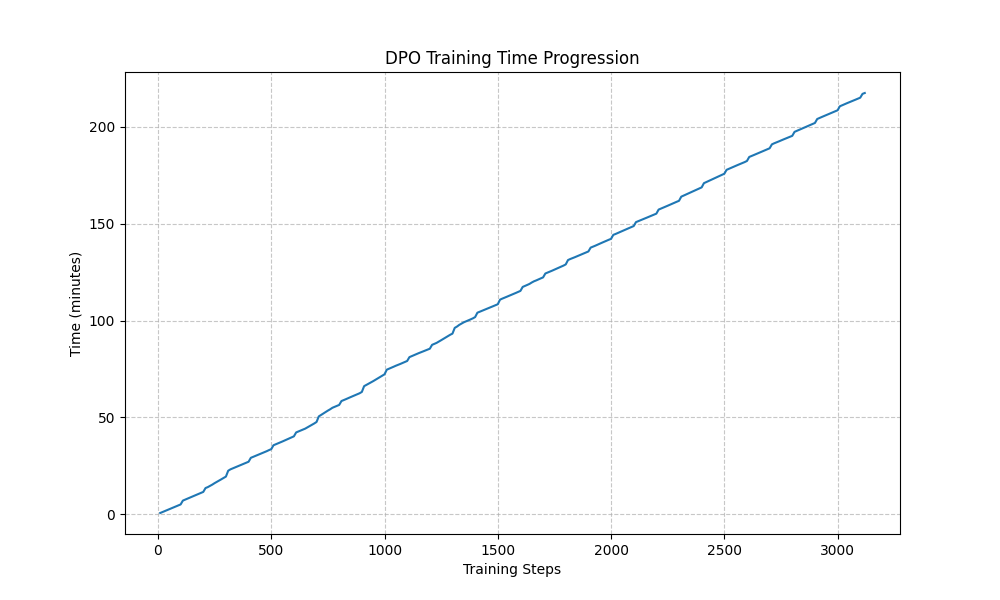

### Loss Plot

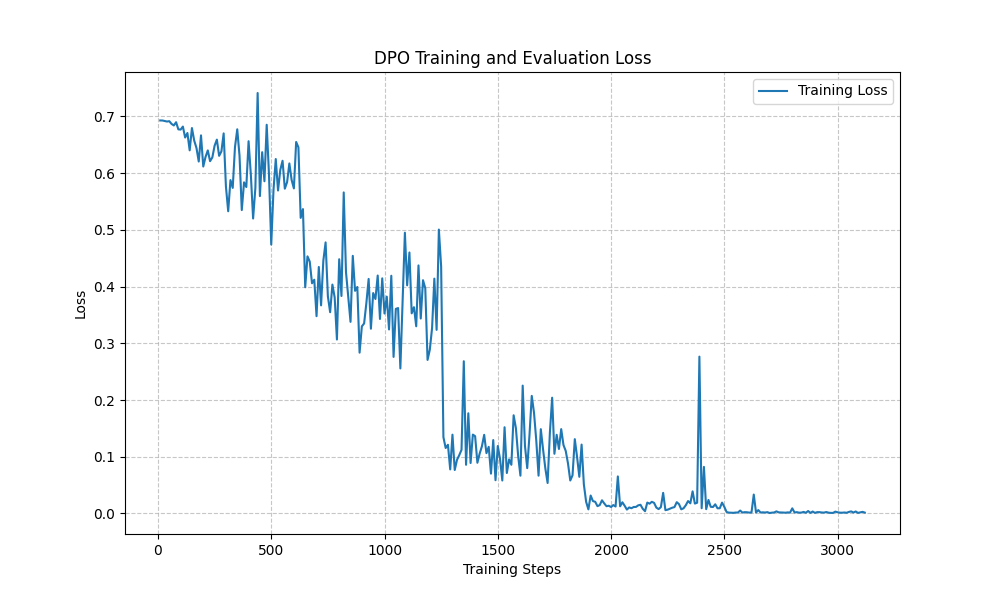

# Task 4. Web Application Development (1 point)✅

1) Develop a simple web application that demonstrates your trained model’s capabilities. ✅
2) The app should allow users to input text and receive response. ✅

# Inference on GPU

In [1]:
from transformers import pipeline

question = "If you had a time machine, but could only go to the past or the future once and never return, which would you choose and why?"
generator = pipeline("text-generation", model="aryashah00/dpo-TinyLlama-1.1B-Chat-v1.0-20250228-2003", device="cuda")
output = generator([{"role": "user", "content": question}], max_new_tokens=512, return_full_text=False)[0]
print(output["generated_text"])


Device set to use cuda


If I had a time machine, I would choose to go to the past because it would allow me to witness the events that shaped the world we live in today. I would love to see how the world was before the Industrial Revolution, how the world was before the rise of modern technology, and how the world was before the rise of globalization. It would be fascinating to see how different societies and cultures were before the modern era.

However, if I had a time machine, I would never want to return to the future. The future is a scary and uncertain place, and I don't want to be stuck in a time when the world is in chaos and uncertainty. I would rather spend my time exploring the past and learning from the mistakes of the past.

In conclusion, if I had a time machine, I would choose to go to the past because it would allow me to witness the world as it was before, while also learning from the mistakes of the past.


# Inference on CPU

In [5]:
from transformers import pipeline

question = "If you had a time machine, but could only go to the past or the future once and never return, which would you choose and why?"
generator = pipeline("text-generation", model="aryashah00/dpo-TinyLlama-1.1B-Chat-v1.0-20250228-2003", device="cpu")
output = generator([{"role": "user", "content": question}], max_new_tokens=512, return_full_text=False)[0]
print(output["generated_text"])

Device set to use cpu


If I had a time machine, I would choose to go to the past because it would allow me to witness the events that shaped the world we live in today. I would love to see how the world was before the Industrial Revolution, how the world was before the rise of modern technology, and how the world was before the rise of globalization. It would be fascinating to see how different societies and cultures were before the modern era.

However, if I had a time machine, I would never want to return to the future. The future is a scary and uncertain place, and I don't want to be stuck in a time when the world is in chaos and uncertainty. I would rather spend my time exploring the past and learning from the mistakes of the past.

In conclusion, if I had a time machine, I would choose to go to the past because it would allow me to witness the world as it was before, while also learning from the mistakes of the past.


# Thank You! 🤗